In [1]:
# imports
import numpy as np
import os

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# image handling
from PIL import Image

# plotting
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
class PlayerTilesDataset(Dataset):
    """Image Loader dataset for player tiles."""
    def __init__(self, dirname, transform=None):
        """
        Args:
            root (string): Path to the images organized in a team\player\image.jpg format.
            transform: Any Pytorch transform to be applied
        """
        
        # initalise image paths
        self.image_paths = []
        
        # initialse image labels
        self.labels = []
        
        # get all team folders
        teams = [f.name for f in os.scandir(dirname) if f.is_dir()]

        # iterate over each team folder
        for team in list(teams):

            # create team directory
            teams_dir = os.path.join(dirname,team)

            # get all players for that team
            players = [f.name for f in os.scandir(teams_dir) if f.is_dir()]

            # iterate over each player
            for player in list(players):

                # create player directory
                player_dir = os.path.join(dirname,team,player)

                # get all images for that player
                images = [f.name for f in os.scandir(player_dir)]

                # iterate over all images
                for image in images:

                    # append image path
                    self.image_paths.append(os.path.join(dirname,team,player,image))
                    
                    # append labels
                    self.labels.append(team+'_'+player)

        # Create a dictionary mapping each label to a index from 0 to len(classes).
        self.label_to_idx = {x:i for i,x in enumerate(set(self.labels))}
        # Create a dictionary mapping each index to corresponding label
        self.idx_to_label = {ind: label for label, ind in self.label_to_idx.items()}
        
        # transform if requessted
        self.transform = transform
        
    def __len__(self):
        # return length of dataset
        return len(self.image_paths)
      
    def __getitem__(self, idx):
        # open and send one image and label
        
        # get image path
        img_name = self.image_paths[idx]
        
        # get image label
        label = self.labels[idx]
        
        # open image
        image = Image.open(img_name)
        
        # transform if requested
        if self.transform:
            image = self.transform(image)
            
        return image,self.label_to_idx[label]

In [3]:
class Net(nn.Module):
    "Pytorch neural network model class"
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(6 * 112 * 112, 84)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 54)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1,6 * 112 * 112)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# set directory of folder holding all images
imdir = 'part1'

# transform images to tensor
t = transforms.ToTensor()

# load dataset
train_dataset = PlayerTilesDataset(dirname=imdir,transform=t)

In [5]:
# set targets
targets = train_dataset.labels

def get_target_counts(targets):
    # count instances of each class in targets
    return {target_class: targets.count(target_class) for target_class in set(targets)}


def print_target_counts(targets):
    target_counts = get_target_counts(targets)
    total_targets = 0
    for target in target_counts:
        total_targets += target_counts[target]
    for target in target_counts:
        print('{} : {}, {:.1f}%'.format(target,target_counts[target],100*target_counts[target]/total_targets))
        
print('Number of instances in each class of WHOLE dataset:')
print_target_counts(targets)

Number of instances in each class of WHOLE dataset:
spal_team_a_person_6 : 4, 0.2%
wigan_person_21 : 33, 1.3%
bristol_person_31 : 28, 1.1%
bristol_person_23 : 113, 4.3%
nottingham_forrest_person_8 : 23, 0.9%
bristol_person_5 : 87, 3.3%
bristol_person_14 : 161, 6.1%
nottingham_forrest_person_3 : 11, 0.4%
bristol_person_6 : 73, 2.8%
middlesbrough_person_6 : 97, 3.7%
middlesbrough_person_5 : 39, 1.5%
nottingham_forrest_person_23 : 72, 2.7%
nottingham_forrest_person_7 : 123, 4.7%
nottingham_forrest_person_19 : 32, 1.2%
wigan_person_22 : 15, 0.6%
spal_team_b_person_10 : 6, 0.2%
spal_team_a_person_77 : 22, 0.8%
spal_team_a_person_15 : 29, 1.1%
wigan_person_15 : 6, 0.2%
nottingham_forrest_person_11 : 9, 0.3%
nottingham_forrest_person_28 : 43, 1.6%
spal_team_b_person_37 : 47, 1.8%
nottingham_forrest_person_18 : 9, 0.3%
bristol_person_45 : 82, 3.1%
bristol_person_9 : 20, 0.8%
middlesbrough_person_8 : 77, 2.9%
wigan_person_19 : 58, 2.2%
spal_team_b_person_23 : 9, 0.3%
middlesbrough_person_26 : 4

In [6]:
# Split data into train 70%, validation 20% and test 10%
# Use stratify to ensure equal weighting of each class
# First split into train and the rest
train_idx, rest_idx = train_test_split(np.arange(len(targets)),test_size=0.3, random_state=42, 
                                        shuffle=True, stratify=targets)
# set train targets and assign the targets of the remaining samples
train_targets = [targets[i] for i in train_idx]
rest_targets = [targets[i] for i in rest_idx]

# next split rest into validation and test
valid_idx, test_idx = train_test_split(np.arange(len(rest_targets)),test_size=0.33, random_state=42, 
                                        shuffle=True)

# refer valid_idx and test_idx back to rest_idx
valid_idx = rest_idx[valid_idx]
test_idx = rest_idx[test_idx]

# set validation and test target values
valid_targets = [targets[i] for i in valid_idx]
test_targets = [targets[i] for i in test_idx]

In [7]:
# Print some information
# First, number of training, validation and test samples
print("Number of training samples: ", len(train_idx))
print("Number of validation samples: ", len(valid_idx))
print("Number of test samples: ", len(test_idx))

# Print the number of instances in each set
# Each individual set has a similar proportion to the whole dataset as required
print('Number of instances in each class of TRAIN dataset:')
print_target_counts(train_targets)
print('\n')
print('Number of instances in each class of VALID dataset:')
print_target_counts(valid_targets)
print('\n')
print('Number of instances in each class of TEST dataset:')
print_target_counts(test_targets)

Number of training samples:  1845
Number of validation samples:  529
Number of test samples:  262
Number of instances in each class of TRAIN dataset:
wigan_person_21 : 23, 1.2%
spal_team_a_person_6 : 3, 0.2%
bristol_person_31 : 20, 1.1%
bristol_person_23 : 79, 4.3%
nottingham_forrest_person_8 : 16, 0.9%
bristol_person_5 : 61, 3.3%
bristol_person_14 : 113, 6.1%
nottingham_forrest_person_3 : 8, 0.4%
nottingham_forrest_person_23 : 50, 2.7%
bristol_person_6 : 51, 2.8%
middlesbrough_person_5 : 27, 1.5%
nottingham_forrest_person_7 : 86, 4.7%
middlesbrough_person_6 : 68, 3.7%
nottingham_forrest_person_19 : 22, 1.2%
wigan_person_22 : 11, 0.6%
spal_team_b_person_10 : 4, 0.2%
spal_team_a_person_77 : 15, 0.8%
spal_team_a_person_15 : 20, 1.1%
wigan_person_15 : 4, 0.2%
nottingham_forrest_person_11 : 6, 0.3%
nottingham_forrest_person_28 : 30, 1.6%
spal_team_b_person_37 : 33, 1.8%
nottingham_forrest_person_18 : 6, 0.3%
bristol_person_45 : 57, 3.1%
bristol_person_9 : 14, 0.8%
middlesbrough_person_8 : 

In [8]:
# Set up train, validation and test dataloaders
# Train and validation are sampled randomly
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
# test is not sampled randomly so images can be iterated in order for visualisation
test_sampler = torch.utils.data.Subset(train_dataset,test_idx)

# train and validation have batch size set. test has batch size of 1 to process each image separately
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_sampler, batch_size=1, shuffle=False)

In [9]:
# function to return the correct number of predictions from predictions and labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


In [10]:
# TRAIN MODEL

# initialise model
model = Net()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10
# iterate over each epoch
for epoch in range(num_epochs):
    
    # initialise total loss and total_correct variables
    total_loss = 0
    total_correct = 0
    
    # set model to train mode
    model.train()
    
    # iterate over batches in training dataset
    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = model(images) # pass batch to model forward pass
        loss = F.cross_entropy(preds, labels) # calculate Loss

        optimizer.zero_grad() # zero greadients
        loss.backward() # calculate Gradients
        optimizer.step() # update Weights

        total_loss += loss.item() # add loss to total loss
        total_correct += get_num_correct(preds, labels) # add prediction to total correct
    
    # set model to evaluate
    model.eval()
    
    # initialise total loss and total_correct for validation set
    val_total_loss = 0
    val_total_correct = 0
    
    # iterate over eatch batch in validation set
    for val_batch in valid_loader:
        val_images, val_labels = val_batch
        
        val_pred = model(val_images) # make predcitions
        val_loss = F.cross_entropy(val_pred, val_labels) # calculate losses
        
        val_total_loss += val_loss.item() # add to total loss
        val_total_correct += get_num_correct(val_pred,val_labels) # add prediction to total correct
    
    # print epoch results
    print(
        'epoch: {},'.format(epoch), 
        'total_correct:{},'.format(total_correct), 
        'loss: {:.1f},'.format(total_loss),
        'validation_total_correct: {}'.format(val_total_correct),
        'validation_loss: {:.1f},'.format(val_total_loss)

    )

epoch: 0, total_correct:86, loss: 240.2, validation_total_correct: 25 validation_loss: 33.8,
epoch: 1, total_correct:139, loss: 104.6, validation_total_correct: 55 validation_loss: 31.2,
epoch: 2, total_correct:232, loss: 95.8, validation_total_correct: 89 validation_loss: 29.5,
epoch: 3, total_correct:402, loss: 84.0, validation_total_correct: 145 validation_loss: 25.6,
epoch: 4, total_correct:600, loss: 69.8, validation_total_correct: 163 validation_loss: 22.2,
epoch: 5, total_correct:721, loss: 58.3, validation_total_correct: 174 validation_loss: 22.2,
epoch: 6, total_correct:858, loss: 51.3, validation_total_correct: 180 validation_loss: 22.6,
epoch: 7, total_correct:949, loss: 47.2, validation_total_correct: 193 validation_loss: 21.9,
epoch: 8, total_correct:1061, loss: 41.4, validation_total_correct: 215 validation_loss: 24.5,
epoch: 9, total_correct:1094, loss: 37.8, validation_total_correct: 206 validation_loss: 23.7,


In [11]:
# EVALUATE MODEL

# initialise prediction and target variables for training, validation and test set
train_predictions = []
train_targets = []
val_predictions = []
val_targets = []
test_predictions = []
test_targets = []
# also initialise loss and total correct variables for test set
test_total_loss = 0
test_total_correct = 0

# iterate over each training batch
for batch in train_loader: # get batch
    train_images, train_labels = batch 
    train_preds = model(train_images) # get predictions for batch
    train_predictions.extend(train_preds.argmax(dim=1)) # append predictions
    train_targets.extend(train_labels) # append truth

# iterate over each validation batch
for batch in valid_loader: # get batch
    val_images, val_labels = batch 
    val_preds = model(val_images) # get predictions for batch
    val_predictions.extend(val_preds.argmax(dim=1)) # append predictions
    val_targets.extend(val_labels) # append truth

# iterate over each test sample
for test_image,test_label in test_loader: # get sample
    test_pred = model(test_image) # get prediction
    test_predictions.append(test_pred.argmax(dim=1)) # append prediction
    test_targets.append(test_label) # append truth
    test_loss = F.cross_entropy(test_pred, test_label) # calculate loss
    test_total_loss += test_loss.item() # add loss
    test_total_correct += get_num_correct(test_pred,test_label)# add total correct

In [12]:
# convert predictions and ground truth targets from index to labels

# training set
train_prediction_labels = [train_dataset.idx_to_label[p.item()] for p in train_predictions]
train_target_labels = [train_dataset.idx_to_label[p.item()] for p in train_targets]

# validation set
val_prediction_labels = [train_dataset.idx_to_label[p.item()] for p in val_predictions]
val_target_labels = [train_dataset.idx_to_label[p.item()] for p in val_targets]

# test set
test_prediction_labels = [train_dataset.idx_to_label[p.item()] for p in test_predictions]
test_target_labels = [train_dataset.idx_to_label[p.item()] for p in test_targets]

In [13]:
# evaluate accuracy of training, validation and test set predictions

train_accuracy = accuracy_score(train_target_labels,train_prediction_labels)
val_accuracy = accuracy_score(val_target_labels,val_prediction_labels)
test_accuracy = accuracy_score(test_target_labels,test_prediction_labels)

print('Training dataset accuracy: {:.1f}%'.format(100*train_accuracy))
print('Validation dataset accuracy: {:.1f}%'.format(100*val_accuracy))
print('Test dataset accuracy: {:.1f}%'.format(100*test_accuracy))

Training dataset accuracy: 63.5%
Validation dataset accuracy: 38.9%
Test dataset accuracy: 32.4%


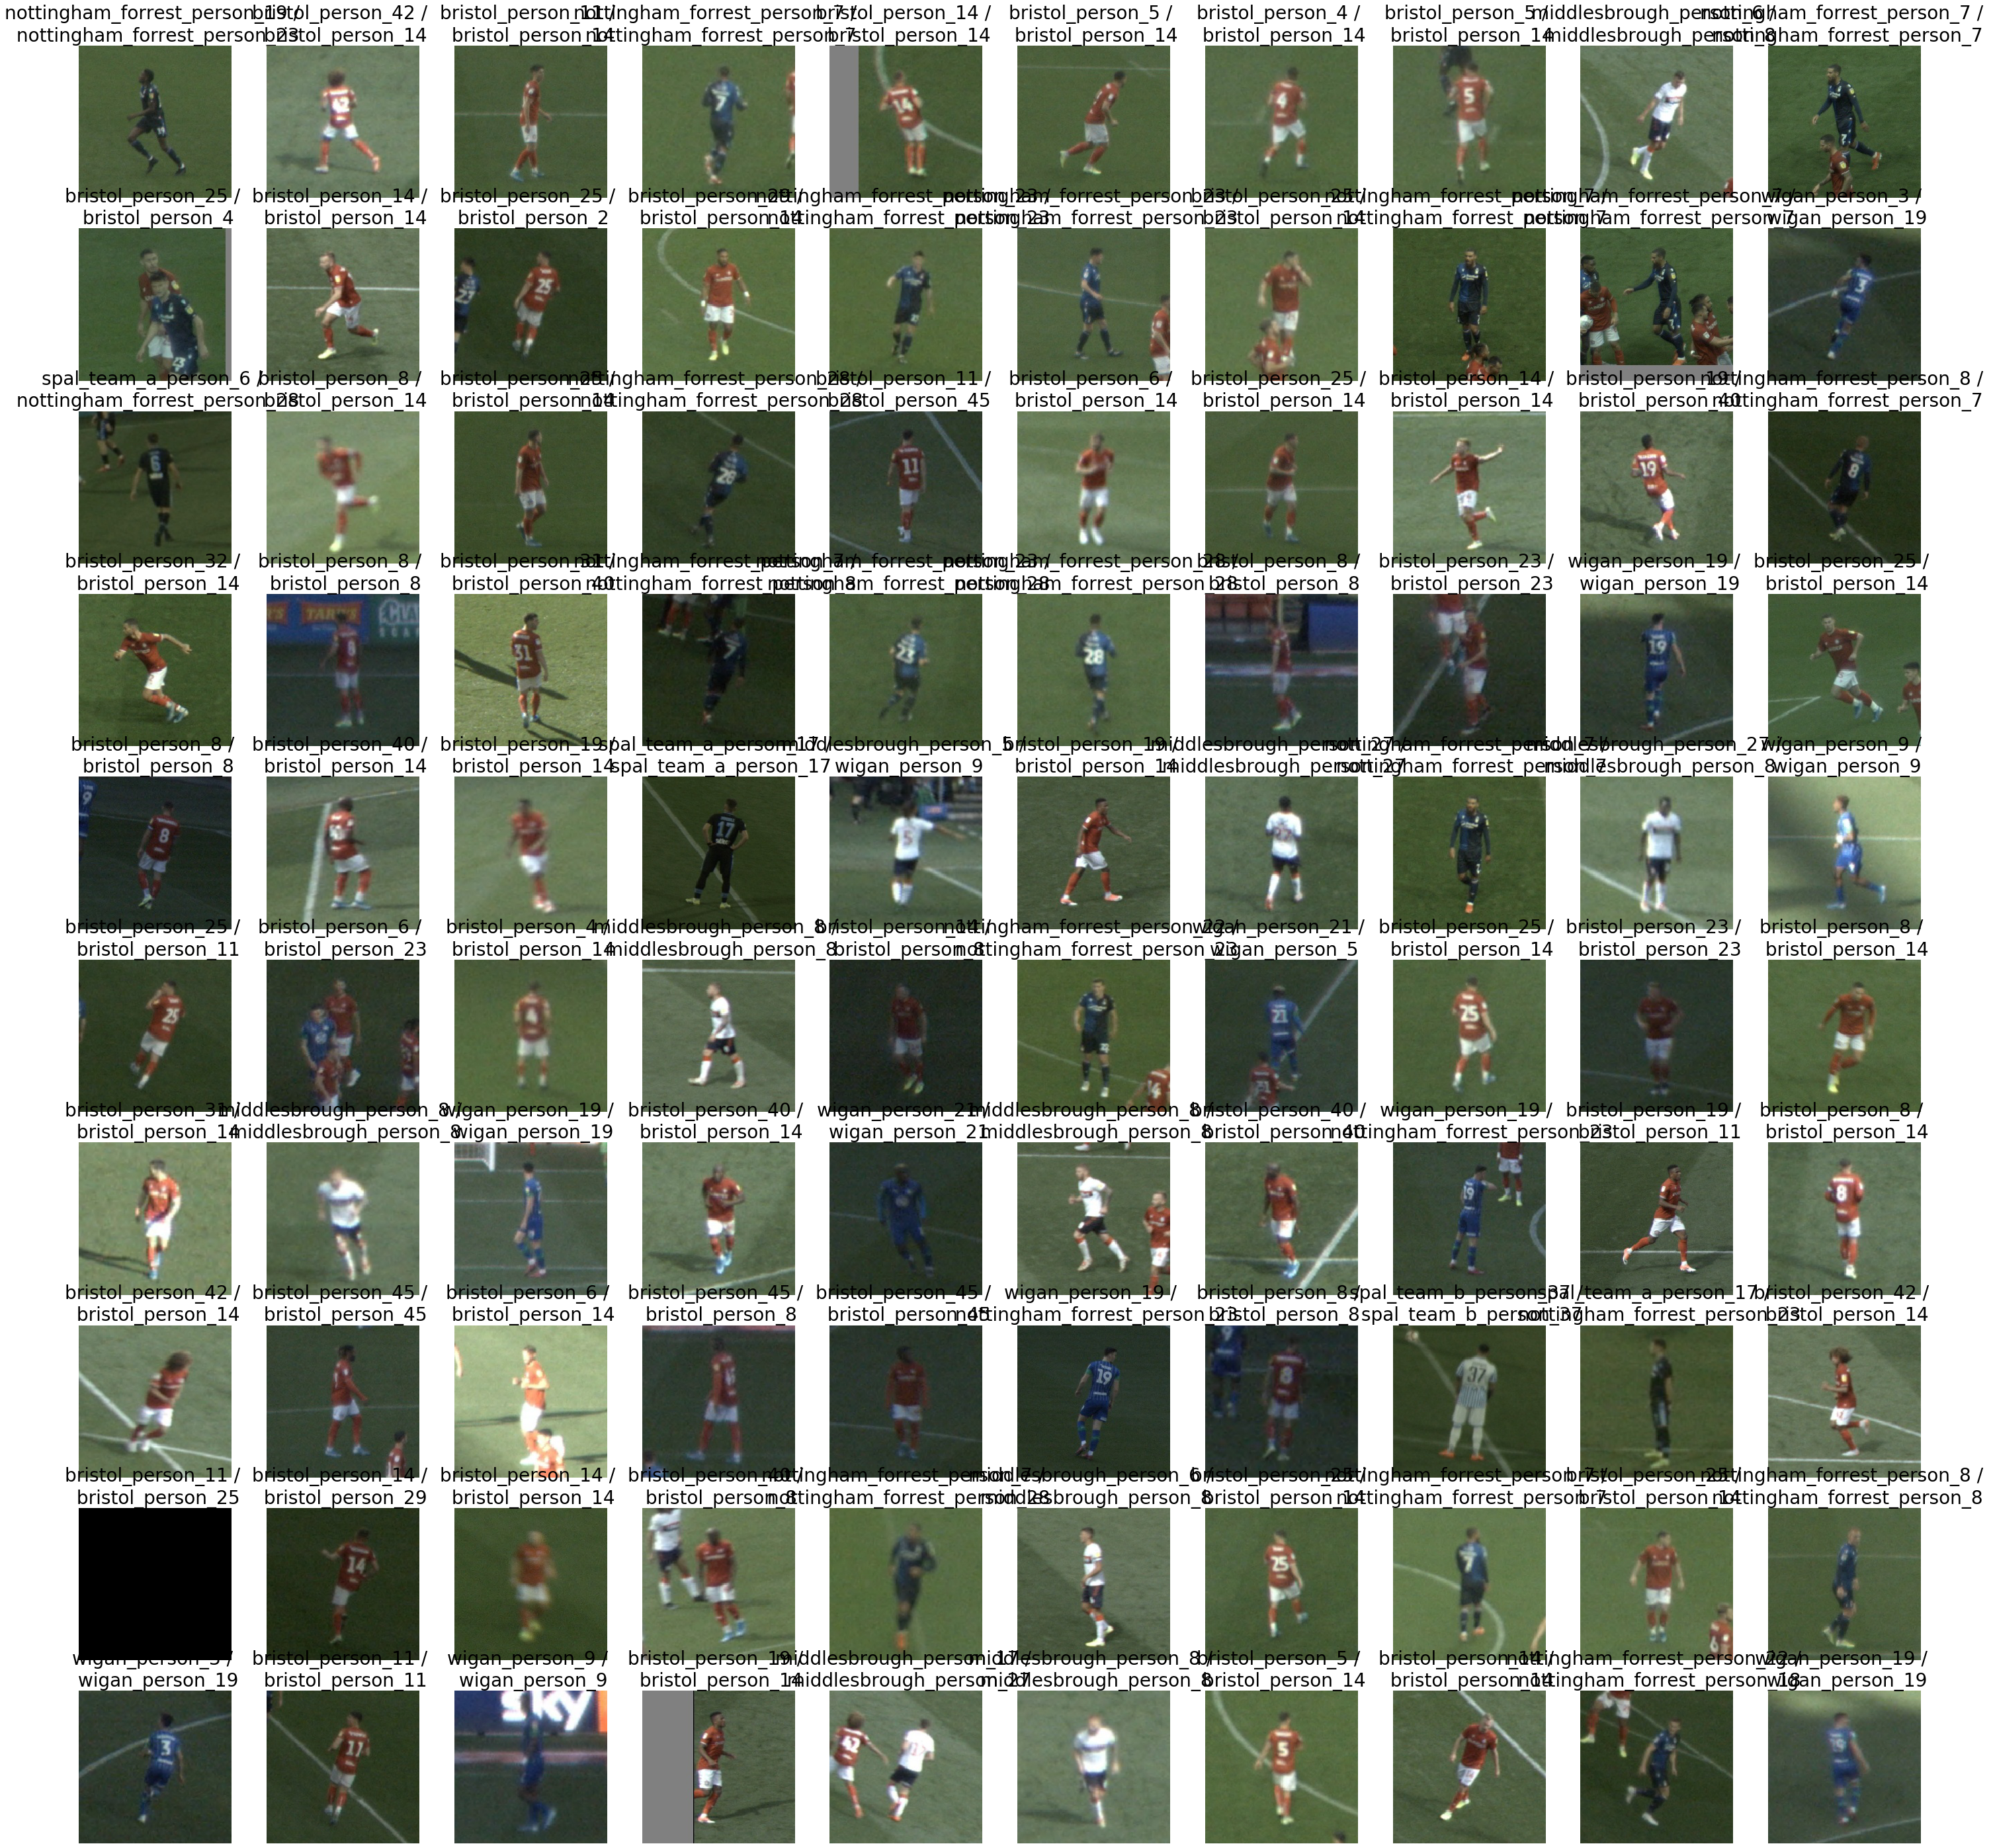

In [14]:
# PLOT SOME RESULTS FROM TEST SET

how_many_to_plot = 100 # how many tiles to plot
plt.figure(figsize=(50,50))

# iterate over test set
for i, [image,label] in enumerate(test_loader):
    plt.subplot(10,10,i+1)
    plt.imshow(image.squeeze().permute(1,2,0))
    plt.axis('off')
    
    # get prediction for image
    test_pred_idx = model(image).argmax(dim=1)
    # convert prediction from index to label
    test_pred_label = train_dataset.idx_to_label[test_pred_idx.item()]
    
    # create title for each image with ground truth & prediction
    imtitle = train_dataset.idx_to_label[label.item()] + ' / \n ' +  test_pred_label
    # plot image
    plt.title(imtitle, fontsize=28)
    
    # stop if exceeded max number to plot
    if (i >= how_many_to_plot-1): break
plt.show()

In [15]:
# SAVING MODEL
# get example input from test set
example_im, example_label  = next(iter(test_loader))

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example_im)

# test output
output = traced_script_module(example_im)
print(output)

# save model
traced_script_module.save("person_model.pt")

tensor([[-2.1810, -3.1147, -4.0446, -4.3428, -1.6643, -4.1462, -1.5280, -0.3423,
         -3.0195, -2.6002, -3.1577,  2.1084, -0.2603, -0.5455, -3.0294, -5.1194,
         -1.5738, -4.0031, -6.2907, -3.3125,  0.6092, -5.7175, -1.3368, -4.6387,
         -3.2826, -4.1001, -0.6435, -5.7152, -5.8831, -3.8442, -3.2735, -2.6233,
         -4.6445, -2.7563, -0.8072, -1.5394, -0.8675, -2.3622, -1.8547, -5.5695,
         -2.0773,  1.6829, -1.7578, -3.5117, -4.1608, -7.1228, -6.1098, -5.2572,
         -4.0588, -2.0661, -5.5079, -7.2251, -3.5091, -1.2911]],
       grad_fn=<AddBackward0>)
